# Part 1 - Generate Map, Warehouses & Test Data



## Import Libraries

In [121]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pulp
import pickle
from statistics import median
import statistics
import scipy.stats as stats
import time
import simpy
our_seed = 9525

## Define functions for points

Create the distance between two points & a function to find the nearest link between two point sets

In [25]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP  

## Code to generate graphs

In [137]:
def generateRandomGraph(n, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    r = rounding(r)
    x0 = r
    y0 = r
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = r//gridsize*gridsize
    split = 2*r//gridsize+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) <= r*1.2 ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [138]:
def plotGraph(P, E,location, col='b', grid=False,):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()
    plt.savefig(location)

## Testing Graph

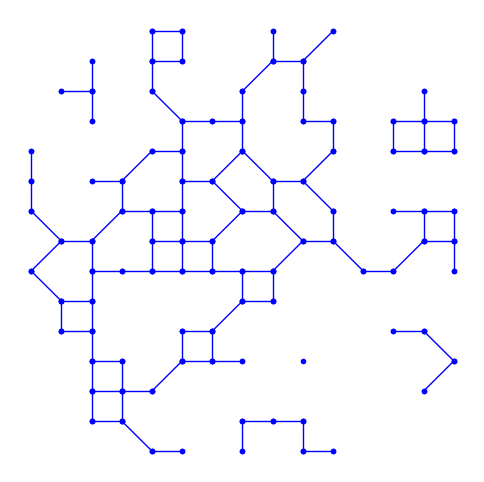

In [139]:
random.seed(our_seed)
V, E = generateRandomGraph(100, 4500)
disconnected_plot = plotGraph(V, E,location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\disconected_graph.png")


Since the figure above has nodes that are not connected to the rest of the nodes, these are called sub-graphs. For this project, there must be no sub-graphs. This would lead to the possibility of houses being in subgraphs with no access for the delivery driver.

In [123]:
def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ] 
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E    

## Lists and Paths

In [30]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [124]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

In [125]:
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [126]:
def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

In [127]:
def totalLength(edges):
    return sum([ dist(A, B) for A,B in edges ])

## Generate Customer Data

In [128]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [129]:
def generateRandomTargets(M, n=5):
    V, E = M
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 200
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [130]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## Plot Map With Delivery Route

In [131]:
def label(i):
    return (label(i//26-1)+chr(65+i%26)) if i>25 else chr(65+i)

In [132]:
def plotMap(G, location=None,T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=3,
            styleP='b-o', lwP=2, msP=3,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, labels=False, scale=False):


    V, E = G

    def round_down(x, level): return (x//level)*level
    def round_up(x, level): return (x//level+1)*level
    
    xmin = round_down(min([ x for (x, _) in V ]), 100)
    xmax = round_up(max([ x for (x, _) in V ]), 100)
    ymin = round_down(min([ y for (_, y) in V ]), 100)
    ymax = round_up(max([ y for (_, y) in V ]), 100)
    dx = xmax-xmin
    dy = ymax-ymin
    yoffset = (ymax-ymin)//10
    
    fig = plt.gcf()
    fig.set_size_inches(4, 4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin-yoffset, ymax)
    
    if not grid:
        plt.axis('off')

    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    if scale:
        # plot 1000m scale
        ybar = ymin-0.9*yoffset
        D = [ (xmin, ybar+50), (xmin, ybar), (xmin+1000, ybar), (xmin+1000, ybar+50) ]
        plt.plot( [ d[0] for d in D ], [ d[1] for d in D ], 'k-', lw=0.5)
        plt.text(xmin+500, ymin-0.7*yoffset, '1000m' , horizontalalignment='center', size=8)
    
    if labels:
        for i in range(len(V)):
            x, y = V[i]
            plt.text(x+0.0150*dx, y-0.0350*dy, label(i), size=8)
        
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
        
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(xmax, ymin-0.7*yoffset, text, horizontalalignment='right', size=8)
    if grid:
        plt.grid()
    if location: 
        plt.savefig(location)
    plt.show()

In [133]:
def generateGraph(n, r):
    P, E = generateRandomGraph(n, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

## Generate Data

generateData is a function that takes in the seed value (student number), a number of nodes, customers, a plot value, if you would like the data plotted & a log value - if you would like to know it was successful

In [134]:
def generateData(seed=None, nodes=35, customers=100, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=35, customers=100, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations.")
        print("")
        print("  nodes the number of intersections (nodes, vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
        scale = False
            
    else:
        grid = False
        scale = True
        
    random.seed(seed)
    
    M = generateGraph(nodes, 4500)
    
    C = generateRandomTargets(M, customers)
    
    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap(M, T=C, scale=scale, text=label, grid=grid)
    
    return M, C

Now that the data can be generated, a quick test can be done to ensure we have replicable results. 

In [135]:
D1 = generateData(our_seed)
D2 = generateData(our_seed)
D1 == D2

True

Ensure that the above is "True" before proceeding. This ensured that the code is set up correctly and the generateData function can produce replicable results

## Generate project map and customers

The next stage is to use the above functions to generate the map, M and customers, C that will be used for this project

In [142]:
M, C = generateData(our_seed)

## Generating  Data

### Test Data

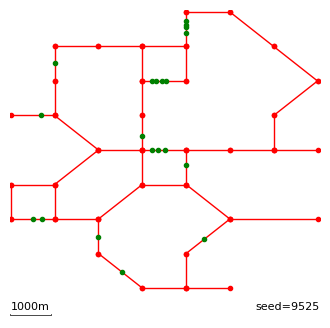

In [190]:
testData = generateData(seed = 9525, nodes=35, customers=20, plot=True)

In [191]:
import pickle
with open('testData.pickled', 'wb') as f:
    pickle.dump(testData, f)

### Project Data

Generated map with 35 nodes and 100 customer locations


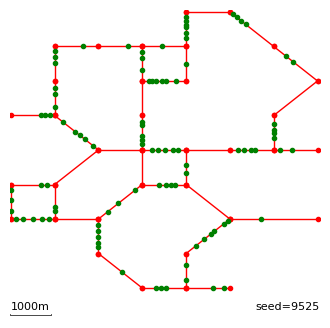

In [192]:
ProjectData = generateData(seed=our_seed, log=True, plot=True)

In [193]:

with open('ProjectData.pickled', 'wb') as f:
    pickle.dump(ProjectData, f)
    

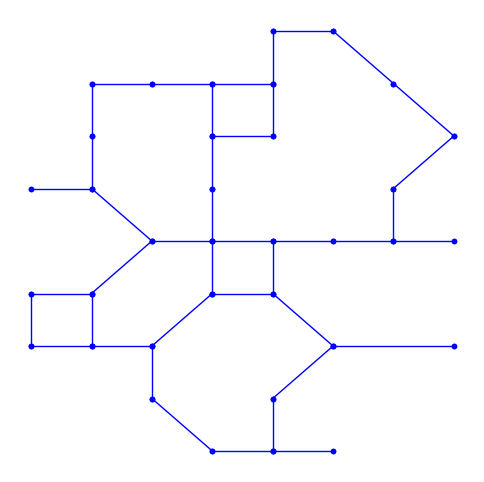

In [194]:
M, C = FullData
V,E = M

plotGraph(V, E,location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\testData.png")

## Generate Warehouse Location

The Next step in the project is to generate the first warehouse location, the code is set up so this is somewhere in the center of the map. 

In [199]:

def generateWarehouseLocation(M):
    V, _ = M
    xc = median([ x for (x, y) in V ])
    yc = median([ y for (x, y) in V ])
    cloc = (xc, yc)
    minloc = V[0]
    mindist = dist(minloc, cloc)
    for i in range(1, len(V)):
        d = dist(V[i], cloc)
        if d<mindist:
            minloc = V[i]
            mindist = dist(V[i], cloc)
    return minloc

In [201]:
def generateMultipleWarehouseLocations(M, N=5):
    C = generateWarehouseLocation(M)
    V, _ = M
    distances = [ (i, pathLength(shortestPath(M, V[i], C))) for i in range(len(V)) ]
    faraway = sorted(distances, key=lambda x: x[1], reverse=True)
    index = [ i*(len(faraway)-1)//(N-1) for i in range(N)]
    locations = [ V[faraway[i][0]] for i in index ]
    return locations

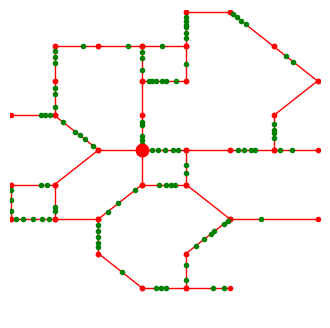

In [200]:
W = generateWarehouseLocation(M)
plotMap((V, E),location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\warehouselocation1.png", T=C, w=W)

# Generating the Delivery Data

In [202]:
def generateDeliveries(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    random.seed(seed)
    deliveries = [ [ ] for _ in range(days) ]
    for c in range(C):
        arr = 0
        while True:
            arr += random.expovariate(p)
            day = int(arr)
            if day>=days:
                break
            deliveries[day].append(c)
    return deliveries 

# Finding the shortest path

The A* Algorithm

In [203]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [204]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

Update to our seed?

In [206]:
D = generateDeliveries(0.2, 10, 5, seed=our_seed)
D

[[], [2, 3, 4, 5], [7], [], []]

In [208]:
def simulateDeliveriesPerDay(p, C=100, days=100, n=1000):
    deliveries = []
    for seed in range(n):
        D = generateDeliveries(p, C, 50, seed=seed)
        deliveries += [len(d) for d in D]
    
    mind = min(deliveries)
    maxd = max(deliveries)
    
    plt.hist(deliveries, bins=maxd-mind+1, density=True)
    plt.title(f"Total Parcels per Day p={p:4.2f}, C={C:d} (days={days:d}, n={n:d})")
    poisson=stats.poisson(p*C)
    X = range(mind, maxd+1)
    plt.plot( X, [ poisson.pmf(x) for x in X ], color='red', marker='o')
    plt.show()

In [209]:
def simulateDeliveriesPerCustomer(p, days=100, C=100, n=1000, log=False):
    total = [ 0 for c in range(C) ]
    mind = maxd = int(p*days)
    counts = [0]
    assert(len(counts) == maxd-mind+1)
    for seed in range(n):
        deliveries = [ 0 for c in range(C) ]
        D = generateDeliveries(p, C, days, seed=seed)
        for d in D:
            for c in d:
                deliveries[c] += 1
                
        # extend count to the left if required
        for i in range(mind-min(deliveries)):
            counts = [0] + counts
        # extend count to the right if required
        for i in range(max(deliveries)-maxd):
            counts = counts + [0]
        mind = min(mind, int(min(deliveries)))
        maxd = max(maxd, int(max(deliveries)))
        assert(len(counts) == maxd-mind+1)
        
        for c in range(C):
            counts[deliveries[c]-mind] += 1

    if not log:
        for i in range(len(counts)):
            counts[i] = counts[i]/(n*C)
            
    plt.bar(x=[str(i) for i in range(mind, maxd+1)], height=counts, log=log)
    plt.title(f"Parcels per Customer p={p:4.2f}, days={days:d} (C={C:d}, n={n:d})")

    poisson=stats.poisson(p*days)
    X = range(mind, maxd+1)
    Y = [ poisson.pmf(x) for x in X ]
    
    if log:
        Y = [ n*C*y for y in Y ]
    
    plt.plot( X, Y, color='red', marker='o')
    plt.show()

## Statistical Analysis

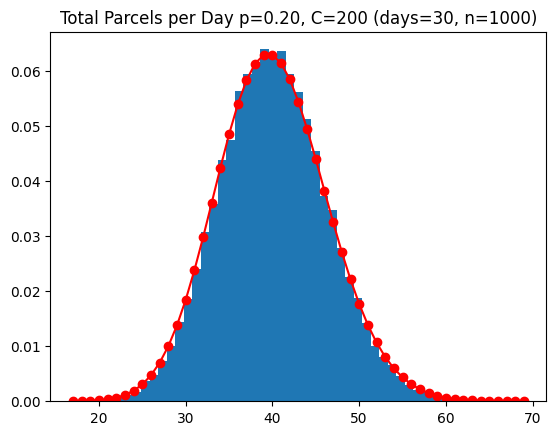

In [210]:
simulateDeliveriesPerDay(0.2, C=200, days=30)

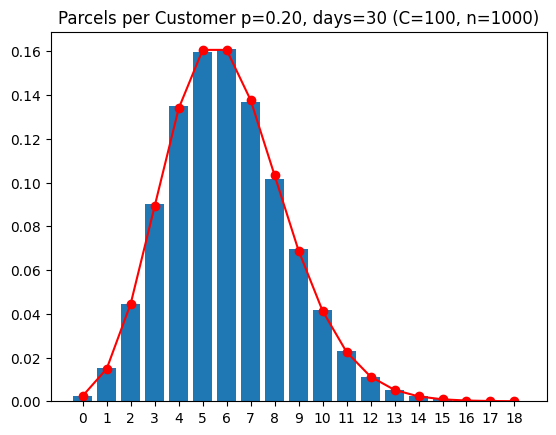

In [211]:
simulateDeliveriesPerCustomer(0.2, days=30)

# Delivery Route Algorithms

## Greedy Algorithm

Space for info on the greedy algorithm

In [212]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [213]:
def createLoopG(M, T, plot=False, timing=False):

    def makeLoop(V, P, L):
        loop = []
        for i in range(len(L)-1):
            sub = P[V.index(L[i])][V.index(L[i+1])]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
        
    if timing:
        start_time = time.time()

    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    # D, P = createTables(M, T)   # note these are the distances between all vertices in M (and T)
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:2]+[T[0]]
        T = T[2:]
        while len(T)>0:
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):  
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            if plot:
                print('-'.join([ label(V.index(l)) for l in L ]))
                loop = makeLoop(V, P, L)
                plotMap(M, T=L, P=loop, w=W, labels=True, 
                        text=f"{len(L):d} steps {pathLength(loop):,d}m")
                
    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(V, P, L)

In [214]:
import pickle
with open('TestData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [215]:
W = generateWarehouseLocation(M)

In [216]:
random.seed(our_seed)
T = random.sample(C, k=len(C)//2)

In [217]:
MC = addTargets(M, T)

In [218]:
PG = createLoopG(MC, [W]+T, plot=False)

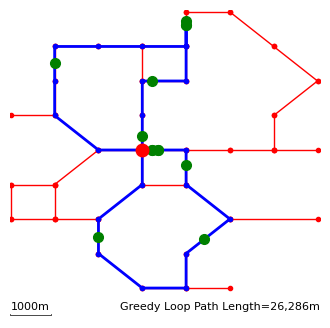

In [221]:
plotMap(MC, T=T, w=W, P=PG, scale=True, text=f"Greedy Loop Path Length={pathLength(PG):3,d}m")

## Statistics of Greedy Delivery Path Length

In [222]:
def simulateGreedyPathLength(p, M, C, days=10, seed=0, log=False):
    D = generateDeliveries(p, len(C), days=days, seed=seed)
    L = []
    for d in range(len(D)):
        T = [ C[c] for c in set(D[d]) ]
        MT = addTargets(M, T)
        P = createLoopG(MT, [W]+T)
        PL = pathLength(P)
        L.append(PL)

    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    ax = fig.gca()
    delta = 1000
    def roundDown(x): return x//delta*delta
    def roundUp(x): return (x//delta+1)*delta
    mind = roundDown(min(L))
    maxd = roundUp(max(L))
    bins = [ l for l in range(mind, maxd+delta, delta) ]
    res = plt.hist(L, bins=bins, log=log)
    mean = statistics.mean(L)
    ax.axvline(x=mean, color='red')
    yt = 0.95*max(res[0])
    xt = 0.02*(max(res[1])-min(res[1]))
    ax.text(mean+xt, yt, f'μ={mean:2.2f}', color='red', fontsize=10)
    plt.title(f"Greedy Delivery Path Length p={p:4.2f}, C={len(C):d} (days={days:d})")
    plt.show()

Test (delete)

In [223]:
import pickle
with open('TestData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [224]:
W = generateWarehouseLocation(M)

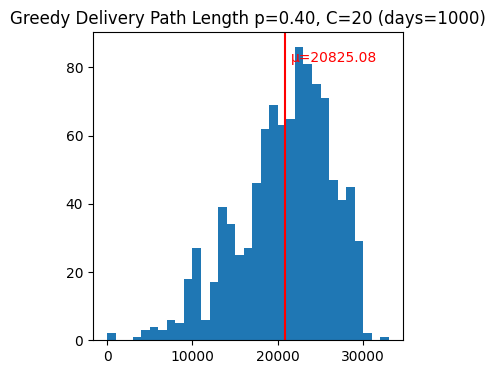

In [225]:
simulateGreedyPathLength(0.4, M, C, days=1000)

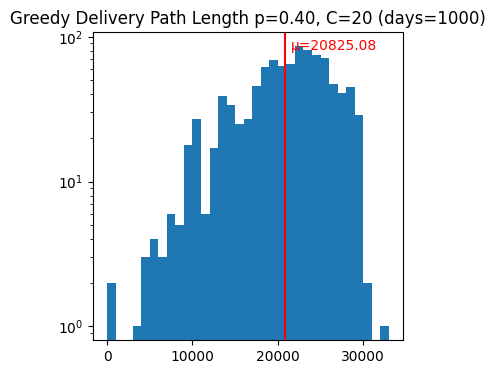

In [226]:
simulateGreedyPathLength(0.4, M, C, days=1000,log=True)

## Finding Optimal Delivery Path

In [227]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p       

In [228]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [229]:
def createLoop(M, T, timing=False):
    
    if timing:
        start_time = last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
                
    def cycles(k, n):
        if k==1:
            return [ [i] for i in range(0,n) ]
        else:
            sc=cycles(k-1, n)
            all=[]
            for c in sc:
                for i in range(0,n):
                    if c.count(i)==0:
                        all.append(c+[i])
            return all

    for k in range(3, 4):   
        cycs=cycles(k,n)
        for c in cycs:
            c.append(c[0])
            prob+=pulp.lpSum([ x[c[i]][c[i+1]] for i in range(0,k)]) <= k-1
            constraints += 1    
            
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0, timeLimit=2)
    res = prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()
        
    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
                
        res = prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

## Testing (delete?)

In [230]:
import pickle
with open('TestData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [231]:
print(M)
print(C)

([(1320, 2380), (1320, 3440), (1320, 5560), (2380, 2380), (2380, 3440), (2380, 5560), (2380, 6620), (2380, 7680), (3440, 1320), (3440, 2380), (3440, 4500), (3440, 7680), (4500, 260), (4500, 3440), (4500, 4500), (4500, 5560), (4500, 6620), (4500, 7680), (5560, 260), (5560, 1320), (5560, 3440), (5560, 4500), (5560, 6620), (5560, 7680), (5560, 8740), (6620, 260), (6620, 2380), (6620, 4500), (6620, 8740), (7680, 4500), (7680, 5560), (7680, 7680), (8740, 2380), (8740, 4500), (8740, 6620)], [((1320, 2380), (1320, 3440)), ((2380, 2380), (1320, 2380)), ((2380, 2380), (2380, 3440)), ((2380, 2380), (3440, 2380)), ((2380, 3440), (1320, 3440)), ((2380, 5560), (1320, 5560)), ((2380, 5560), (2380, 6620)), ((2380, 5560), (3440, 4500)), ((2380, 6620), (2380, 7680)), ((2380, 7680), (3440, 7680)), ((3440, 1320), (3440, 2380)), ((3440, 1320), (4500, 260)), ((3440, 4500), (2380, 3440)), ((3440, 4500), (4500, 4500)), ((4500, 260), (5560, 260)), ((4500, 3440), (3440, 2380)), ((4500, 3440), (4500, 4500)), ((

In [232]:
W = generateWarehouseLocation(M)
random.seed(our_seed)


In [233]:
T = random.sample(C, k=len(C)//2)
MC = addTargets(M, T)


In [234]:
P = createLoop(MC, [W]+T)


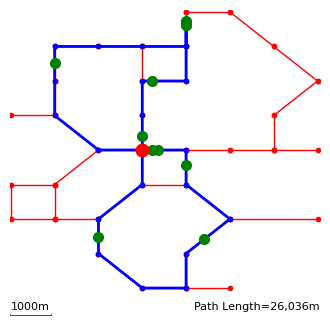

In [235]:
plotMap(MC, T=T, w=W, P=P, scale=True, text=f"Path Length={pathLength(P):3,d}m")

Comparing with the optimal delivery route with the result of the greedy algorithm:

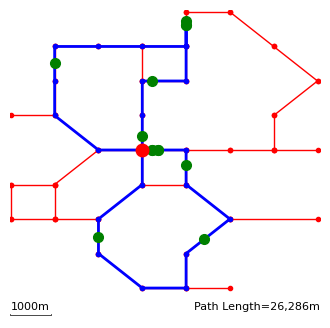

In [237]:
plotMap(MC, T=T, w=W, P=PG, scale=True, text=f"Path Length={pathLength(PG):3,d}m")

In [252]:
def simulateOptimalPathLength(p, M, C, days=10, seed=0, log=False,location=None):
    D = generateDeliveries(p, len(C), days=days, seed=seed)
    L = []
    for d in range(len(D)):
        T = [ C[c] for c in set(D[d]) ]
        MT = addTargets(M, T)
        P = createLoop(MT, [W]+T)
        PL = pathLength(P)
        L.append(PL)
        

    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(4)
    ax = fig.gca()
    delta = 1000
    def roundDown(x): return x//delta*delta
    def roundUp(x): return (x//delta+1)*delta
    mind = roundDown(min(L))
    maxd = roundUp(max(L))
    bins = [ l for l in range(mind, maxd+delta, delta) ]
    res = plt.hist(L, bins=bins, log=log)
    mean = statistics.mean(L)
    ax.axvline(x=mean, color='red')
    yt = 0.95*max(res[0])
    xt = 0.02*(max(res[1])-min(res[1]))
    ax.text(mean+xt, yt, f'μ={mean:2.2f}', color='red', fontsize=10)
    plt.title(f"Optimal Delivery Path Length p={p:4.2f}, C={len(C):d} (days={days:d})")
    if location:
        plt.savefig(location)
    plt.show()

In [278]:
D = generateDeliveries(0.4, len(C), days=30,seed=our_seed)
for d in D:
    print(d)

[1, 3, 5, 8, 9, 14]
[9, 11, 11, 13, 17, 18]
[1, 4, 4, 6, 9, 12, 14]
[3, 4, 4, 7, 8, 10, 10, 11, 12, 15, 17, 18]
[3, 4, 11, 11, 11, 16, 17, 19]
[7]
[1, 5, 14]
[1, 2, 4, 5, 9, 11, 11, 12, 15, 15, 15, 18]
[2, 6, 6, 6, 7, 8, 8, 8, 9, 11, 13, 15, 19]
[1, 5, 7, 8, 9, 11, 11, 13, 18]
[6, 9, 9, 10, 11, 13]
[5, 7, 8, 13, 15, 19]
[0, 5, 7, 11, 12, 13, 13, 19]
[1, 3, 3, 4, 7, 9, 14, 15, 17]
[2, 3, 6, 8, 8, 11, 15, 16, 17, 18]
[6, 8, 9, 12]
[0, 1, 2, 3, 4, 6, 10, 11, 12, 17, 17]
[0, 4, 5, 9, 16]
[2, 2, 4, 4, 7, 9, 13, 14, 14, 18]
[1, 5, 6, 7, 7, 16]
[1, 3, 4, 5, 6, 9, 12, 13, 13, 13, 16]
[0, 2, 6, 6, 9, 11, 15, 16, 16]
[0, 6, 8, 11, 12, 14, 18]
[1, 4, 4, 8, 8, 15, 16, 19]
[2, 13, 14, 15, 18]
[1, 9, 10, 12, 13, 16, 16, 17, 18]
[5, 9, 11, 19]
[1, 8, 13, 15, 16]
[0, 3, 7, 8]
[0, 6, 8, 8, 9, 9, 10, 10, 14, 18, 18]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


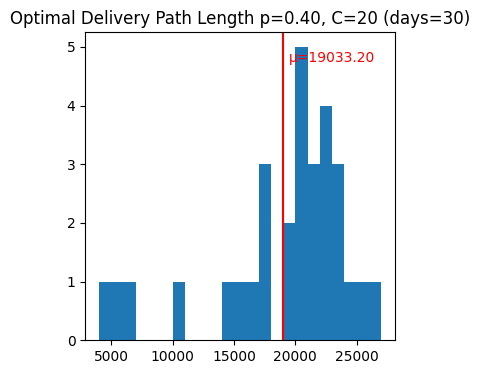

In [277]:
simulateOptimalPathLength(0.4, M, C, days=30,seed=our_seed,location=r"C:\Users\steve_niur\Desktop\Modelling, Simulation and Optimisation\X23299525_MSO_Project\optimal_short.png")

## Path Planning for full data - Delete?

In [85]:
import pickle
with open('FullData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [86]:
W = generateWarehouseLocation(M)

In [87]:
len(C)

100

In [88]:
D = generateDeliveries(0.2, len(C), days=10)
for d in D:
    print(d)

[14, 19, 20, 42, 47, 47, 50, 54, 55, 57, 64, 80, 89, 95]
[8, 13, 16, 17, 25, 32, 40, 42, 48, 48, 52, 59, 64, 68, 76, 79, 85, 85, 85, 93, 95, 96, 97, 97]
[1, 19, 25, 41, 46, 48, 50, 51, 56, 60, 60, 61, 63, 67, 68, 75, 81, 81, 97, 98]
[4, 12, 16, 21, 22, 25, 26, 26, 31, 39, 44, 50, 51, 52, 56, 58, 60, 61, 64, 70, 77, 83, 98, 99]
[1, 3, 5, 10, 20, 23, 24, 34, 35, 45, 50, 57, 64, 66, 77, 77, 81, 96]
[4, 9, 15, 15, 17, 19, 55, 58, 59, 59, 60, 62, 63, 70, 73, 73, 90, 92, 93, 93]
[5, 14, 17, 24, 31, 50, 51, 51, 54, 57, 61, 66, 68, 93, 94, 97, 97]
[1, 2, 35, 38, 40, 42, 42, 51, 58, 69, 76, 76, 81, 85, 89, 92]
[7, 8, 9, 14, 15, 18, 25, 38, 39, 40, 45, 56, 67, 67, 70, 72, 75, 83, 93, 94, 96]
[0, 2, 9, 13, 23, 29, 32, 40, 44, 44, 52, 62, 64, 66, 68, 72, 82, 96, 97]


Day 0:


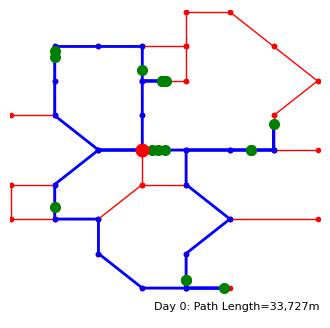

Day 1:


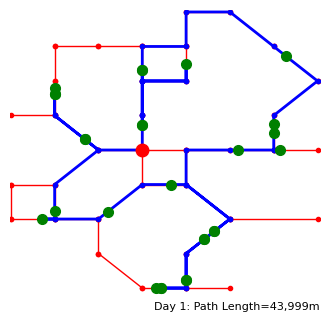

Day 2:


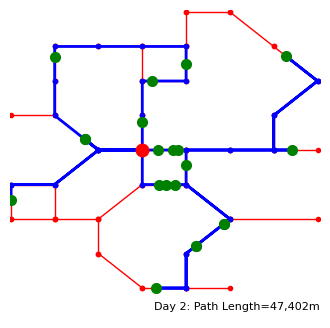

Day 3:


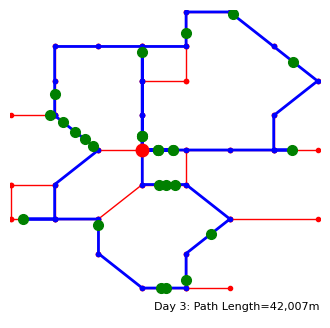

Day 4:


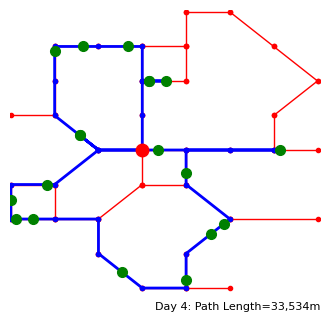

Day 5:


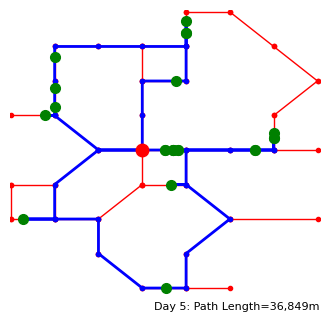

Day 6:


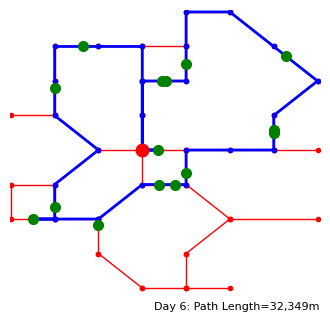

Day 7:


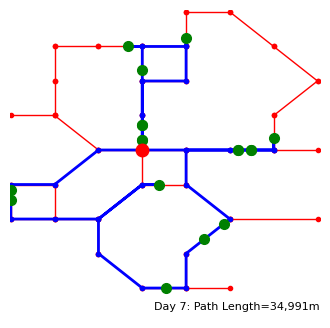

Day 8:


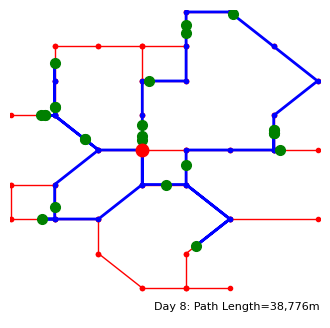

Day 9:


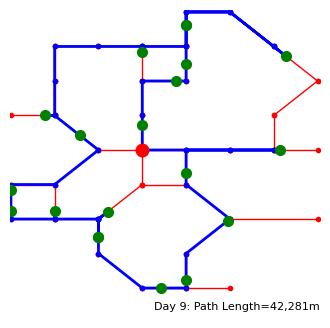

In [89]:
length = []
for d in range(len(D)):
    print(f"Day {d}:")
    T = [ C[c] for c in set(D[d]) ]
    MT = addTargets(M, T)
    P = createLoopG(MT, [W]+T)
    length.append(pathLength(P))
    plotMap(MT, T=T, w=W, P=P, text=f"Day {d}: Path Length={pathLength(P):3,d}m")

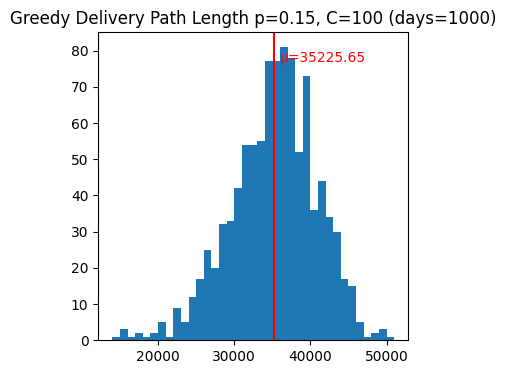

In [90]:
simulateGreedyPathLength(0.15, M, C, days=1000)

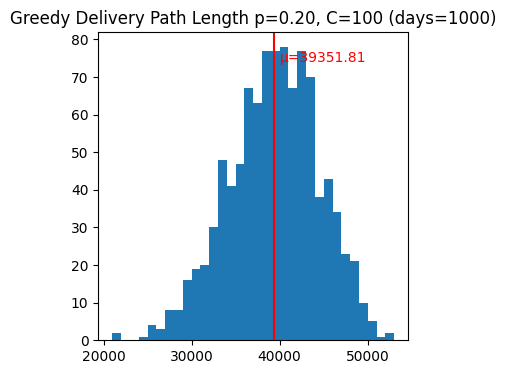

In [91]:
simulateGreedyPathLength(0.2, M, C, days=1000)

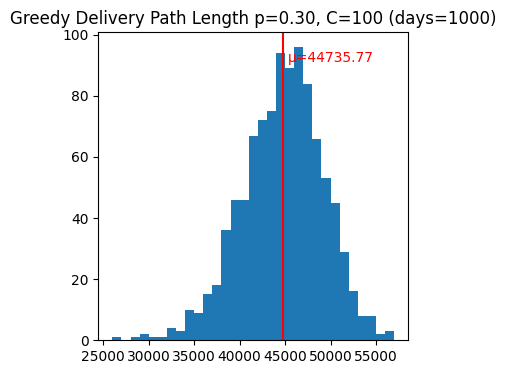

In [92]:
simulateGreedyPathLength(0.3, M, C, days=1000)

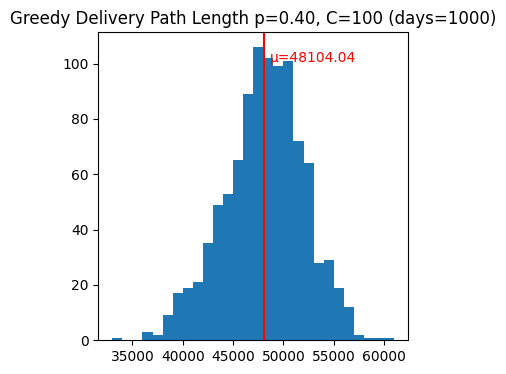

In [93]:
simulateGreedyPathLength(0.4, M, C, days=1000)

# STEP 4

## Time Handling

**Convention:** In this project we measure simulation time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [94]:
def timestamp(t):
    t = round(t, 1)
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t-secs)*10,1)) 
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [95]:
def day(now):
    return int(now//(24*3600))

In [96]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

## Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder. 

In [97]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None

## Class Customer

In [98]:
class Customer:
    
    def __init__(self, rec, id, location):
        self.rec = rec
        self.id = id
        self.location = location
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer {self.id:d} at {str(self.location):s}"
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            answerTime = random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR)
            if answerTime < WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR:                            
                yield self.rec.env.timeout(answerTime)
                self.rec.trace(str(self)+" answers door")
                self.answersDoor = True
            else:
                yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
                self.rec.trace(str(self)+" to slow to answer the door")
                self.answersDoor = False
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec.trace(str(self)+" not at home")
            self.answersDoot = False
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            returnTime = 22 if random.random()<CUSTOMER_NOT_AT_HOME else 18
            yield self.rec.env.timeout(nextHour(self.rec.env, returnTime))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))            


## Class Parcel

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [99]:
class Parcel:
    
    def __init__(self, rec, i, day, cust):
        self.rec = rec
        self.i = i  
        self.arrival = day
        self.cust = cust
        self.status = [  ] # status record and
        self.timing = [  ] # timing

    def __str__(self):
        return f"Parcel {self.i:d} for cust {self.cust.id:d}"

    def index(self):
        return self.i
    
    def destination(self):
        return self.cust.location
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')

## Class Driver

In [100]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.trace("Driver arrives for work")

    def goesHome(self):
        self.location = None
        self.parcels = None
        self.returns = None
        self.tour = None
        self.rec.trace("Driver goes home")
        
    def leaveForDelivery(self, tour, parcels, addresses):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " 
                       f"of {len(parcels):d} parcels "
                       f"to {len(addresses):d} customers")
        self.rec.trace(f"Length of delivery tour: {pathLength(tour):,d}m")
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):d}:, {pathLength(tour):,d}m")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels, addresses = self.DC.sendForDelivery()
            if len(parcels)==0: 
                self.rec.trace("Nothing to do today")
            else:
                yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
                self.leaveForDelivery(tour, parcels, addresses)        
                while len(self.parcels)>0:
                    # drive to customer
                    custLocation = self.parcels[0].destination()
                    cust = self.parcels[0].cust
                    self.rec.trace("Driver drives to "+str(cust))
                    yield from self.__drive(custLocation)
                    self.rec.trace("Driver arrived at "+str(cust))
                    # call at customer
                    yield from cust.answerDoor()
                    
                    if cust.answersDoor:
                        while len(self.parcels)>0 and \
                                custLocation == self.parcels[0].destination():
                            cust.acceptParcel(self.parcels[0])
                            yield self.rec.env.timeout(random.expovariate(1/10))
                            self.parcels = self.parcels[1:]
                        cust.signOff()
                        yield self.rec.env.timeout(random.expovariate(1/10))
                    else:
                        while len(self.parcels)>0 and  \
                                custLocation == self.parcels[0].destination():
                            self.returns += [self.parcels[0]]
                            self.parcels = self.parcels[1:]

                # return to delivery centre
                self.rec.trace("Driver returns to delivery centre")
                yield from self.__drive(self.DC.W)
                self.rec.trace("Driver arrived at delivery centre")
            
                for parcel in self.returns:
                    self.DC.returnFromDelivery(parcel)
                    yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)

                leftOver = len(self.DC.parcels)+len(self.DC.leftOver)
                self.rec.trace(f"{leftOver:d} parcels left for next day")
            
            yield self.rec.env.timeout(600)
        
            self.goesHome()
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

## Class Delivery Service

In [101]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = BIKE_RANGE
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [self.W]  # tour planned for delivery
    
    def __accept(self, parcel):
        custLoc = parcel.destination()
        if custLoc not in self.dest:
            MT = addTargets(self.M, self.dest + [custLoc])
            SH = createLoopG(MT, [self.W] + self.dest + [custLoc])
            if pathLength(SH)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = SH
            else: 
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = []
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.destination() == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()
                    if dest not in addresses:
                        addresses += [dest]
         
        # arrange the left overs for next day
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)

        return tour, parcels, addresses
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        return len(self.parcels)+len(self.leftOver)

## Simulation

## Parameters from Specification

The proportion of customers that for whatever are not at home or return home late

In [102]:
CUSTOMER_NOT_AT_HOME = 0.9  # 10%

The maximum bike range. This is passed as parameter to the Delivery Centre
and taken into account for the daily tour planning

In [103]:
BIKE_RANGE = 40000

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [104]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [105]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [106]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [107]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [108]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

## Generate Input Data

In [109]:
def generateDeliveries(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    random.seed(seed)
    deliveries = [ [ ] for _ in range(days) ]
    for c in range(C):
        arr = 0
        while True:
            arr += random.expovariate(p)
            day = int(arr)
            if day>=days:
                break
            deliveries[day].append(c)
    return deliveries 

## Simulation Routine

In [110]:
def simulation(M, W, C, p=0.2, days=10, seed=0, 
               log=False, plot=False, timing=False):

    random.seed(seed)
    D = generateDeliveries(p, len(C), days, seed)
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, 
                   log=log, plot=plot, timing=timing)

    print(f"Simulating delivery of {sum([len(d) for d in D]):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    CUSTOMERS = []
    for i in range(len(C)):
        CUSTOMERS.append(Customer(rec, i, C[i]))

    DC = DeliveryCentre(rec, M, W)
    Z = Driver(rec, DC)
    PARCELS = []

    def parcelGeneratorProcess(env, rec, D, C):
        for day in range(len(D)):
            yield env.timeout(nextHour(env, 17.00))
            for c in D[day]:
                cust = CUSTOMERS[c]
                parcel = Parcel(rec, len(PARCELS), day, cust)
                PARCELS.append(parcel)
                DC.acceptParcel(parcel)

    env.process(parcelGeneratorProcess(env, rec, D, C))
    env.run()

    rec.finish()

    if DC.getInventory()>0:
        print(f"Delivery Centre Inventory: {DC.getInventory():d} parcels")

    return rec

## Model Verification

In [111]:
import pickle
with open('testData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [112]:
W = generateWarehouseLocation(M)

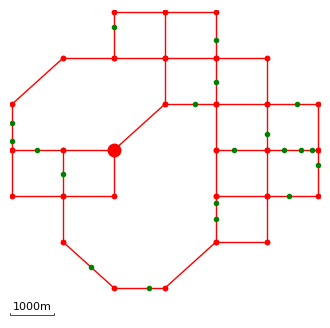

In [113]:
plotMap(M, T=C, w=W, scale=True)

In [114]:
rec1 = simulation(M, W, C, p=0.15, days=4, log=True)

Simulating delivery of 7 parcels over 4 days to 20 customers
[ 0] 17:00:00.0 Parcel 0 for cust 19 arr at delivery centre
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Parcel 0 for cust 19 out for delivery
[ 0] 18:00:50.0 Driver leaves for delivery of 1 parcels to 1 customers
[ 0] 18:00:50.0 Length of delivery tour: 13,208m
[ 0] 18:00:50.0 Driver drives to Customer 19 at (7950, 4122)
[ 0] 18:27:15.0 Driver arrived at Customer 19 at (7950, 4122)
[ 0] 18:28:15.0 Customer 19 at (7950, 4122) not at home
[ 0] 18:28:15.0 Driver returns to delivery centre
[ 0] 18:54:39.9 Driver arrived at delivery centre
[ 0] 18:54:39.9 Parcel 0 for cust 19 return from delivery
[ 0] 18:55:09.9 1 parcels left for next day
[ 0] 19:05:09.9 Driver goes home
[ 1] 17:00:00.0 Parcel 1 for cust 11 arr at delivery centre
[ 1] 18:00:00.0 Driver arrives for work
[ 1] 18:00:00.0 Parcel 0 for cust 19 out for delivery
[ 1] 18:00:00.0 Parcel 1 for cust 11 out for delivery
[ 1] 18:01:40.0 Driver leaves for delivery 

Simulating delivery of 27 parcels over 4 days to 20 customers
[ 0] 17:00:00.0 Parcel 0 for cust 0 arr at delivery centre
[ 0] 17:00:00.0 Parcel 1 for cust 2 arr at delivery centre
[ 0] 17:00:00.0 Parcel 2 for cust 4 arr at delivery centre
[ 0] 17:00:00.0 Parcel 3 for cust 4 arr at delivery centre
[ 0] 17:00:00.0 Parcel 4 for cust 6 arr at delivery centre
[ 0] 17:00:00.0 Parcel 5 for cust 7 arr at delivery centre
[ 0] 17:00:00.0 Parcel 6 for cust 9 arr at delivery centre
[ 0] 17:00:00.0 Parcel 7 for cust 9 arr at delivery centre
[ 0] 17:00:00.0 Parcel 8 for cust 11 arr at delivery centre
[ 0] 17:00:00.0 Parcel 9 for cust 11 arr at delivery centre
[ 0] 17:00:00.0 Parcel 10 for cust 12 arr at delivery centre
[ 0] 17:00:00.0 Parcel 11 for cust 15 arr at delivery centre
[ 0] 17:00:00.0 Parcel 12 for cust 17 arr at delivery centre
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Parcel 8 for cust 11 out for delivery
[ 0] 18:00:00.0 Parcel 9 for cust 11 out for delivery
[ 0] 18:00:00.0

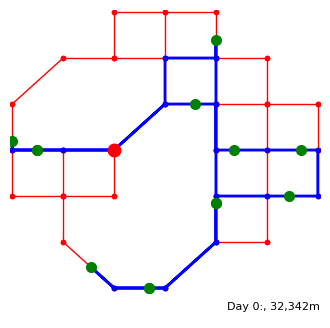

[ 0] 18:10:50.0 Driver drives to Customer 11 at (5650, 7250)
[ 0] 18:28:20.2 Driver arrived at Customer 11 at (5650, 7250)
[ 0] 18:29:20.2 Customer 11 at (5650, 7250) not at home
[ 0] 18:29:20.2 Driver drives to Customer 9 at (5650, 3175)
[ 0] 18:45:38.2 Driver arrived at Customer 9 at (5650, 3175)
[ 0] 18:46:38.2 Customer 9 at (5650, 3175) not at home
[ 0] 18:46:38.2 Driver drives to Customer 6 at (4142, 1050)
[ 0] 18:58:28.4 Driver arrived at Customer 6 at (4142, 1050)
[ 0] 18:59:28.4 Customer 6 at (4142, 1050) not at home
[ 0] 18:59:28.4 Driver drives to Customer 4 at (2821, 1578)
[ 0] 19:05:37.8 Driver arrived at Customer 4 at (2821, 1578)
[ 0] 19:06:37.8 Customer 4 at (2821, 1578) not at home
[ 0] 19:06:37.8 Driver drives to Customer 15 at (7302, 3350)
[ 0] 19:31:55.8 Driver arrived at Customer 15 at (7302, 3350)
[ 0] 19:32:55.8 Customer 15 at (7302, 3350) not at home
[ 0] 19:32:55.8 Driver drives to Customer 17 at (7575, 4500)
[ 0] 19:41:37.3 Driver arrived at Customer 17 at (757

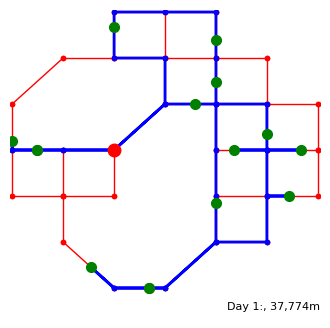

[ 1] 18:16:40.0 Driver drives to Customer 2 at (1618, 4500)
[ 1] 18:23:35.7 Driver arrived at Customer 2 at (1618, 4500)
[ 1] 18:24:35.7 Customer 2 at (1618, 4500) not at home
[ 1] 18:24:35.7 Driver drives to Customer 0 at (1050, 4722)
[ 1] 18:27:45.3 Driver arrived at Customer 0 at (1050, 4722)
[ 1] 18:28:45.3 Customer 0 at (1050, 4722) not at home
[ 1] 18:28:45.3 Driver drives to Customer 7 at (5182, 5650)
[ 1] 18:48:04.5 Driver arrived at Customer 7 at (5182, 5650)
[ 1] 18:48:29.1 Customer 7 at (5182, 5650) answers door
[ 1] 18:48:29.1 Customer 7 at (5182, 5650) accepts Parcel 5 for cust 7
[ 1] 18:48:32.2 Customer 7 at (5182, 5650) signs off
[ 1] 18:48:40.1 Driver drives to Customer 13 at (6800, 4901)
[ 1] 18:58:08.2 Driver arrived at Customer 13 at (6800, 4901)
[ 1] 18:59:08.2 Customer 13 at (6800, 4901) not at home
[ 1] 18:59:08.2 Driver drives to Customer 17 at (7575, 4500)
[ 1] 19:03:50.5 Driver arrived at Customer 17 at (7575, 4500)
[ 1] 19:04:50.5 Customer 17 at (7575, 4500) n

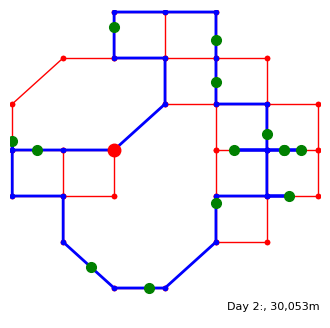

[ 2] 18:20:00.0 Driver drives to Customer 5 at (3350, 7580)
[ 2] 18:38:49.4 Driver arrived at Customer 5 at (3350, 7580)
[ 2] 18:39:49.4 Customer 5 at (3350, 7580) not at home
[ 2] 18:39:49.4 Driver drives to Customer 11 at (5650, 7250)
[ 2] 18:53:18.2 Driver arrived at Customer 11 at (5650, 7250)
[ 2] 18:54:18.2 Customer 11 at (5650, 7250) not at home
[ 2] 18:54:18.2 Driver drives to Customer 10 at (5650, 6203)
[ 2] 18:58:29.5 Driver arrived at Customer 10 at (5650, 6203)
[ 2] 18:59:29.5 Customer 10 at (5650, 6203) not at home
[ 2] 18:59:29.5 Driver drives to Customer 13 at (6800, 4901)
[ 2] 19:09:18.0 Driver arrived at Customer 13 at (6800, 4901)
[ 2] 19:10:18.0 Customer 13 at (6800, 4901) not at home
[ 2] 19:10:18.0 Driver drives to Customer 14 at (7188, 4500)
[ 2] 19:13:27.4 Driver arrived at Customer 14 at (7188, 4500)
[ 2] 19:14:27.4 Customer 14 at (7188, 4500) not at home
[ 2] 19:14:27.4 Driver drives to Customer 17 at (7575, 4500)
[ 2] 19:16:00.2 Driver arrived at Customer 17 a

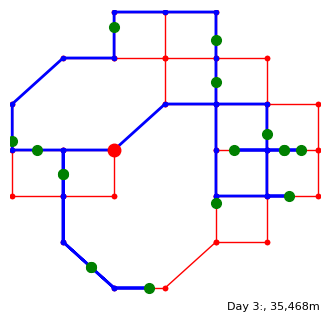

[ 3] 18:21:40.0 Driver drives to Customer 13 at (6800, 4901)
[ 3] 18:40:22.0 Driver arrived at Customer 13 at (6800, 4901)
[ 3] 18:41:22.0 Customer 13 at (6800, 4901) not at home
[ 3] 18:41:22.0 Driver drives to Customer 14 at (7188, 4500)
[ 3] 18:44:31.4 Driver arrived at Customer 14 at (7188, 4500)
[ 3] 18:45:31.4 Customer 14 at (7188, 4500) not at home
[ 3] 18:45:31.4 Driver drives to Customer 17 at (7575, 4500)
[ 3] 18:47:04.2 Driver arrived at Customer 17 at (7575, 4500)
[ 3] 18:48:04.2 Customer 17 at (7575, 4500) not at home
[ 3] 18:48:04.2 Driver drives to Customer 12 at (6061, 4500)
[ 3] 18:54:07.6 Driver arrived at Customer 12 at (6061, 4500)
[ 3] 18:55:07.6 Customer 12 at (6061, 4500) not at home
[ 3] 18:55:07.6 Driver drives to Customer 15 at (7302, 3350)
[ 3] 19:04:41.4 Driver arrived at Customer 15 at (7302, 3350)
[ 3] 19:05:41.4 Customer 15 at (7302, 3350) not at home
[ 3] 19:05:41.4 Driver drives to Customer 9 at (5650, 3175)
[ 3] 19:12:59.9 Driver arrived at Customer 9 

In [115]:
rec2 = simulation(M, W, C, p=0.3, days=4, seed=1, log=True, plot=True)

In [116]:
rec3 = simulation(M, W, C, p=0.6, days=4, log=True)

Simulating delivery of 40 parcels over 4 days to 20 customers
[ 0] 17:00:00.0 Parcel 0 for cust 1 arr at delivery centre
[ 0] 17:00:00.0 Parcel 1 for cust 2 arr at delivery centre
[ 0] 17:00:00.0 Parcel 2 for cust 7 arr at delivery centre
[ 0] 17:00:00.0 Parcel 3 for cust 12 arr at delivery centre
[ 0] 17:00:00.0 Parcel 4 for cust 13 arr at delivery centre
[ 0] 17:00:00.0 Parcel 5 for cust 15 arr at delivery centre
[ 0] 17:00:00.0 Parcel 6 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 7 for cust 19 arr at delivery centre
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Parcel 2 for cust 7 out for delivery
[ 0] 18:00:00.0 Parcel 6 for cust 16 out for delivery
[ 0] 18:00:00.0 Parcel 7 for cust 19 out for delivery
[ 0] 18:00:00.0 Parcel 5 for cust 15 out for delivery
[ 0] 18:00:00.0 Parcel 4 for cust 13 out for delivery
[ 0] 18:00:00.0 Parcel 3 for cust 12 out for delivery
[ 0] 18:00:00.0 Parcel 1 for cust 2 out for delivery
[ 0] 18:00:00.0 Parcel 0 for cust 1 out for d

In [117]:
import pickle
with open('testData.pickled', 'rb') as f:
    MX, CX = pickle.load(f)

In [118]:
WX = generateWarehouseLocation(MX)

In [119]:
rec4 = simulation(MX, WX, CX, p=0.15, days=7, log=True)

Simulating delivery of 14 parcels over 7 days to 20 customers
[ 0] 18:00:00.0 Driver arrives for work
[ 0] 18:00:00.0 Nothing to do today
[ 0] 18:10:00.0 Driver goes home
[ 1] 18:00:00.0 Driver arrives for work
[ 1] 18:00:00.0 Nothing to do today
[ 1] 18:10:00.0 Driver goes home
[ 2] 17:00:00.0 Parcel 0 for cust 4 arr at delivery centre
[ 2] 17:00:00.0 Parcel 1 for cust 12 arr at delivery centre
[ 2] 17:00:00.0 Parcel 2 for cust 19 arr at delivery centre
[ 2] 18:00:00.0 Driver arrives for work
[ 2] 18:00:00.0 Parcel 1 for cust 12 out for delivery
[ 2] 18:00:00.0 Parcel 2 for cust 19 out for delivery
[ 2] 18:00:00.0 Parcel 0 for cust 4 out for delivery
[ 2] 18:02:30.0 Driver leaves for delivery of 3 parcels to 3 customers
[ 2] 18:02:30.0 Length of delivery tour: 18,677m
[ 2] 18:02:30.0 Driver drives to Customer 12 at (6061, 4500)
[ 2] 18:19:50.9 Driver arrived at Customer 12 at (6061, 4500)
[ 2] 18:20:50.9 Customer 12 at (6061, 4500) not at home
[ 2] 18:20:50.9 Driver drives to Customer

In [120]:
rec5 = simulation(MX, WX, CX, p=1.2, days=7, log=True)

Simulating delivery of 151 parcels over 7 days to 20 customers
[ 0] 17:00:00.0 Parcel 0 for cust 5 arr at delivery centre
[ 0] 17:00:00.0 Parcel 1 for cust 6 arr at delivery centre
[ 0] 17:00:00.0 Parcel 2 for cust 6 arr at delivery centre
[ 0] 17:00:00.0 Parcel 3 for cust 7 arr at delivery centre
[ 0] 17:00:00.0 Parcel 4 for cust 7 arr at delivery centre
[ 0] 17:00:00.0 Parcel 5 for cust 8 arr at delivery centre
[ 0] 17:00:00.0 Parcel 6 for cust 13 arr at delivery centre
[ 0] 17:00:00.0 Parcel 7 for cust 13 arr at delivery centre
[ 0] 17:00:00.0 Parcel 8 for cust 15 arr at delivery centre
[ 0] 17:00:00.0 Parcel 9 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 10 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 11 for cust 16 arr at delivery centre
[ 0] 17:00:00.0 Parcel 12 for cust 17 arr at delivery centre
[ 0] 17:00:00.0 Parcel 13 for cust 17 arr at delivery centre
[ 0] 17:00:00.0 Parcel 14 for cust 18 arr at delivery centre
[ 0] 17:00:00.0 Parcel 15 for cust 19 